# PEAK FITTING TUTORIAL (V2)
**V2: Updated Jan 23, 2026** - Reformulated functions to fit pressure amplitude data, not pressure intensity data. Used the driven damped harmonic oscillator equation of motion to introduce a "full" versions of the Lorentzian and Fano lineshapes, which account for non-narrow resonance peaks and further asymmetries coming from low-frequency versus high-frequency responses.

# 1. The Full Lorentzian: the driven damped harmonic oscillator lineshape

In this section we demonstrate fitting voltage (pressure amplitude) vs frequency data from the pipe resonance experiment for the purposes of determining the resonance frequency f<sub>0</sub> and the damping parameter Γ (Gamma), which we will see is related to the width of the peak.

## 1.1 The driven damped harmonic oscillator

We can describe the behaviour of the pressure (x) inside of our pipes in the pipe resonance experiment, when driven by sound of frequency ω near a resonance frequency ω<sub>0</sub>, as 

$$\ddot{x} + \Gamma\dot{x} + \omega_0^2 x = \frac{F_0}{m}\cos(\omega t).$$

Here
* $F_0$ represents how hard the speaker is driving the air column,
* $m$ is an inertia term representing how difficult it is for pressure to push the air in the air column around, and
* $\Gamma$ is a damping term describing how energy is lost from the resonant mode. 

From the solution to this driven damped harmonic oscillator equation, we can parameterize the frequency response of the pressure amplitude near the resonance frequency using the following slightly asymmetric expression:

$$A(f) = \frac{A_\text{peak} \, f_0 \, \Gamma}{\sqrt{(f_0^2 - f^2)^2 + (f \, \Gamma)^2}}.$$

We will refer to this as the *Full Lorentzian* since it reduces to the regular Lorentzian for narrow resonance peaks $(\Gamma \ll f_0)$.

## 1.2 Code for the Full Lorentzian

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def lorentzian(f, A_peak, f0, Gamma):
    """
    Lorentzian (Cauchy) amplitude spectrum 
        Gamma represents Full-Width Half-Maximum for the power (intensity) spectrum
    """
    return A_peak / np.sqrt(1 + ((f - f0) / (Gamma/2))**2)


def lorentzian_full(f, A_peak, f0, Gamma):
    """
    Full Lorentzian: Amplitude response for solution to driven damped harmonic oscillator
        Gamma: Damping parameter (≈ Full-Width Half-Maximum for the power spectrum for narrow resonances)
    """
    return A_peak * f0 * Gamma / np.sqrt((f0**2 - f**2)**2 + (f * Gamma)**2)


def chi_square(fit_function, fit_parameters, x, y, sigma):
    """
    Calculate reduced chi-squared for goodness of fit
    """
    dof = len(x) - len(fit_parameters)
    return np.sum((y - fit_function(x, *fit_parameters))**2 / sigma**2) / dof
    
    

## 1.3 Generate frequency peak data

Let's generate some data with the following characteristics

- **Frequency range**: 380-420 MHz (centered at 400 MHz)
- **Peak amplitude**: 10.0 (Arbitrary Units)
- **Γ (Gamma)**:  of 40.0 MHz
- **Measurement uncertainty**: 0.5 (Arbitrary Units, 5% of peak height)

In [2]:
### Generate data

# Parameters for data generation
A_true = 10       # Peak amplitude (arbitrary units)
f0_true = 400     # Resonance frequency (Hz)
gamma_true = 40   # Γ (Hz)

# Generate frequency axis
x_data = np.linspace(300, 500, 50)  # 50 points from 380 to 420 Hz
x_model = np.linspace(x_data.min(), x_data.max(), 250) # smooth data for curves

# Define constant y-uncertainty
y_sigma = np.full_like(x_data, 0.5)  # Constant measurement uncertainty

# Generate perfect Full Lorentzian profile
y_perfect = lorentzian_full(x_data, A_true, f0_true, gamma_true)

# Add Gaussian noise to simulate experimental data
np.random.seed(314)  # For reproducibility
y_data = y_perfect + np.random.normal(0, y_sigma)

**Visualize the Data:** Before fitting, let's have a look at the data

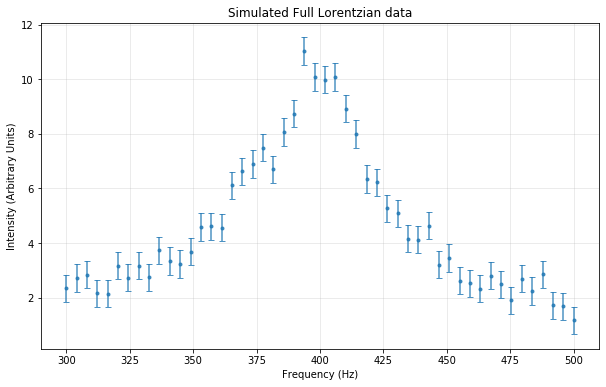

In [3]:
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
             capsize=3, alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (Arbitrary Units)")
plt.title("Simulated Full Lorentzian data")
plt.grid(True, alpha=0.3)
plt.show()

## 1.4 Initial Parameter Guesses

Good initial guesses help the fitting algorithm converge faster and avoid local minima. We can estimate:

**Peal Amplitude (A_peak)**: Maximum y-value in the data

In [4]:
A_guess = np.max(y_data)
print(A_guess)

11.036173074358999


**The resonance frequency (f<sub>0</sub>)** 

In [5]:
f0_guess = x_data[np.argmax(y_data)]
print(f0_guess)

393.8775510204082


**The damping parameter, Gamma (Γ)**: This is approximately equal to the Full-Width at Half-Maximum of the power or intensity spectrum for narrow peaks, but remember we are dealing with the amplitude spectrum, where the power (intensity) spectrum goes like the square of the amplitude spectrum. As a result, Γ can be estimated as the width of the amplitude peak at $A_\text{peak}/\sqrt{2} \approx 0.707\,A_\text{peak}$. Below we estimate this by finding finding the points where $y \geq A/\sqrt{2}$, and then estimate gamma by the distance between the leftmost and rightmost of these points points.

In [6]:
max_over_root2 = A_guess / np.sqrt(2)
indices_half = np.where(y_data >= max_over_root2)[0]
if len(indices_half) >= 2:
    gamma_guess = x_data[indices_half[-1]] - x_data[indices_half[0]]
else:
    gamma_guess = 40  # Fallback default
print(gamma_guess)

28.571428571428555


**Let's visualize the expression that corresponds to these initial guesses.**

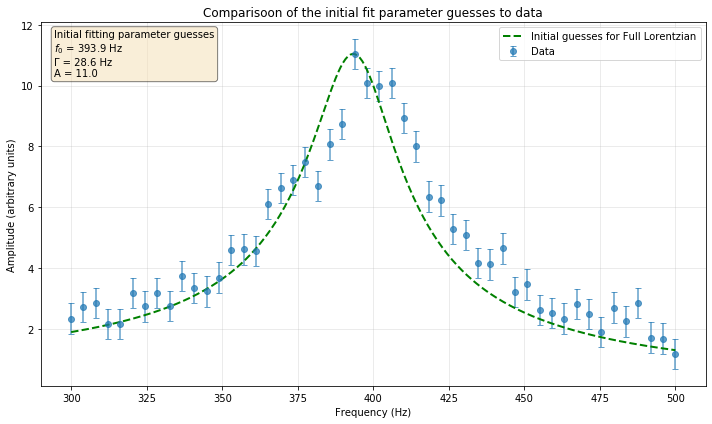

In [7]:
# Visualize initial guesses vs data
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='o', linestyle='', 
             capsize=3, label="Data", alpha=0.7)
plt.plot(x_model, lorentzian_full(x_model, A_guess, f0_guess, gamma_guess), 'g--', linewidth=2, 
         label=f"Initial guesses for Full Lorentzian")
# Initial guesses: A={A_guess:.1f}, \nf₀={f0_guess:.1f} Hz, Γ={gamma_guess:.1f} Hz

# Add text box with initial guesses
textstr = '\n'.join([
    'Initial fitting parameter guesses',
    f'$f_0$ = {f0_guess:.1f} Hz',
    f'Γ = {gamma_guess:.1f} Hz',
    f'A = {A_guess:.1f}'
])
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (arbitrary units)")
plt.title("Comparisoon of the initial fit parameter guesses to data")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**For reference, let's also compare to the regular Lorentzian that would correspond to these guesses.**

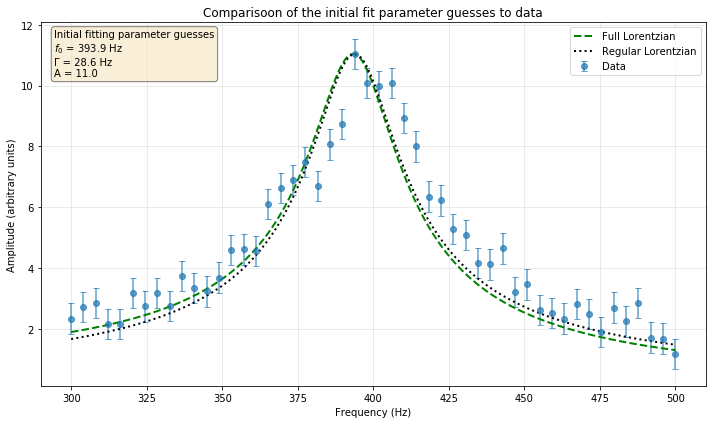

In [8]:
# Visualize initial guesses vs data
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='o', linestyle='', 
             capsize=3, label="Data", alpha=0.7)
plt.plot(x_model, lorentzian_full(x_model, A_guess, f0_guess, gamma_guess), 'g--', linewidth=2, 
         label=f"Full Lorentzian")
plt.plot(x_model, lorentzian(x_model, A_guess, f0_guess, gamma_guess), 'k:', linewidth=2, 
         label=f"Regular Lorentzian")
# Initial guesses: A={A_guess:.1f}, \nf₀={f0_guess:.1f} Hz, Γ={gamma_guess:.1f} Hz

# Add text box with initial guesses
textstr = '\n'.join([
    'Initial fitting parameter guesses',
    f'$f_0$ = {f0_guess:.1f} Hz',
    f'Γ = {gamma_guess:.1f} Hz',
    f'A = {A_guess:.1f}'
])
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (arbitrary units)")
plt.title("Comparisoon of the initial fit parameter guesses to data")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion:** We see in the above plot that for $\Gamma / f_0 \approx 10\%$, the Full Lorentzian is slightly asymmetric as compared to the Regular Lorentzian. This inverse of this quantity is referred to as the *quality factor*, $Q = f_0 / \Gamma$, and is typically 5-20 for all but the shortest pipes that you might use in the the lab.

## 1.5 Perform and visualize the fit with the Full Lorentzian

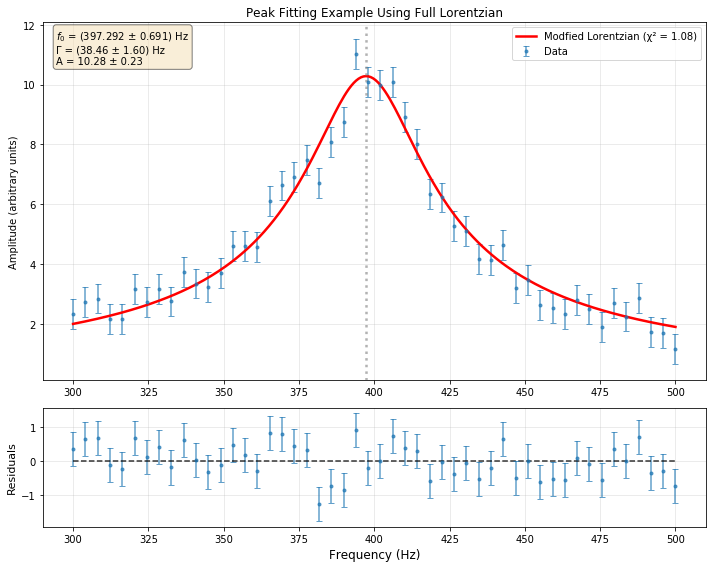

In [9]:
# Perform weighted least-squares fit

p0_guesses = [A_guess, f0_guess, gamma_guess]

fit_params, fit_cov = curve_fit(
    lorentzian, x_data, y_data,
    p0 = p0_guesses,
    sigma = y_sigma,       # Include y uncertainties
    absolute_sigma = True  # Scale fit parameter uncertainties correctly
)

# Extract fitted parameters and uncertainties
A_fit, f0_fit, gamma_fit = fit_params
A_unc, f0_unc, gamma_unc = np.sqrt(np.diag(fit_cov))

# Calculate reduced chi-squared
chi2 = chi_square(lorentzian_full, fit_params, x_data, y_data, y_sigma)

# Make plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8), 
                       gridspec_kw={'height_ratios': [3, 1]})

# Top panel: Data + fit + Gamma visualization
y_fit = lorentzian(x_model, *fit_params)

ax[0].errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
               capsize=3, label="Data", alpha=0.7)
ax[0].plot(x_model, y_fit, 'r-', linewidth=2.5, 
           label=f"Modfied Lorentzian (χ² = {chi2:.2f})")

# Mark center with vertical line
ax[0].axvline(f0_fit, color='gray', linestyle=':', linewidth=2.5, alpha=0.6)

# Add text box with fit parameters
textstr = (
    f'$f_0$ = ({f0_fit:.3f} ± {f0_unc:.3f}) Hz\n'
    + f'Γ = ({gamma_fit:.2f} ± {gamma_unc:.2f}) Hz\n'
    + f'A = {A_fit:.2f} ± {A_unc:.2f}'
)
ax[0].text(0.02, 0.98, textstr, transform=ax[0].transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[0].set_ylabel("Amplitude (arbitrary units)") 
ax[0].set_title(f"Peak Fitting Example Using Full Lorentzian")
ax[0].legend(loc='upper right')
ax[0].grid(True, alpha=0.3)

# Bottom panel: Residuals
residual = y_data - lorentzian(x_data, *fit_params)
ax[1].errorbar(x_data, residual, yerr=y_sigma, marker='.', linestyle='', capsize=3, alpha=0.7)
ax[1].hlines(0, np.min(x_data), np.max(x_data), lw=1.5, alpha=0.8, color="k", linestyle="--")
ax[1].set_xlabel("Frequency (Hz)", fontsize=12)
ax[1].set_ylabel("Residuals", fontsize=11)
ax[1].grid(True, alpha=0.3)
ax[1].legend

plt.tight_layout()
plt.show()

**Discussion:** Given that we used the Full Lorentzian function with Gaussian noise to generate these data, it is no surprise that this ended up being a good fit. Our chi-squared is approximately 1 and our residuals show good scattern and no obvious patterns.

# 2. Fano peak fitting for asymmetric resonance peaks

You may find that the resonance data you collect in Phys 229 has a clear peak, but is much too asymmetric to be described by our Full Lorenzian function. An example of a very asymmetric data set is shown below.

This happens due to a phenomenon known as [Fano resonance](https://en.wikipedia.org/wiki/Fano_resonance), which in our pipe resonance experiment manifests when the standing wave in the pipe interferes with the sound wave coming directly from the speaker. The consequence is that the frequencies fall off asymmetrically on either side of the resonance peak due due to a frequency-dependent phase difference between the direct sound wave and the standing wave. 

You may wish to try moving the microphone or the speaker slightly to see how you changing the path length of the direct sound wave (i.e., the distance between the microphone and speaker) impacts how asymmetric your amplitude-frequency data are.

## 2.1 Load data showing Fano resonance asymmetry

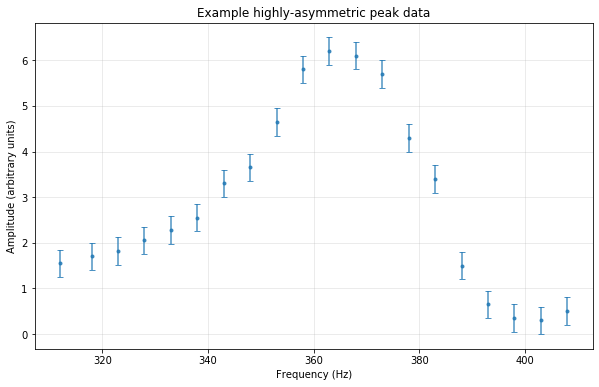

In [10]:
# Load and plot our asymmetric data

# Frequency data
x_data = np.array([312, 318, 323, 328, 333, 338, 343, 348, 353, 358, 
                 363, 368, 373, 378, 383, 388, 393, 398, 403, 408])

# Voltage data
y_data = np.array([1.55, 1.70, 1.82, 2.05, 2.28, 2.55, 3.30, 3.65, 4.65, 5.80,
                      6.20, 6.10, 5.70, 4.30, 3.40, 1.50, 0.65, 0.35, 0.30, 0.50])

y_sigma = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 
                      0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

x_model = np.linspace(np.min(x_data), np.max(x_data), 250) # smooth data for curves

plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
             capsize=3, alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (arbitrary units)")
plt.title("Example highly-asymmetric peak data")
plt.grid(True, alpha=0.3)
plt.show()

## 2.2 Defining the Fano resonance amplitude response function

Fano resonance is described by the following function, where the function approaches our Full Lorenzian as the magnitude of the asymmetry parameter `q` approaches infinity. This function also includes the frequency-dependent denominator introduced in the Full Lorentzian to more correctly account for non-narrow peaks.

In [11]:
def fano_full(f, f0, Gamma, q, A_peak, y_offset):
    """
    Fano amplitude response with full damped driven harmonic oscillator denominator, 
    parameterized by peak height

    f0       : Resonant frequency
    Gamma    : Damping parameter
    q        : Asymmetry parameter (|q|→∞ gives Full Lorentzian)
    A_peak   : Peak height above y_offset
    y_offset : Background offset
    """
    epsilon = (f - f0) / (Gamma / 2)
    D_full = ((f0**2 - f**2) / (f0 * Gamma))**2 + (f / f0)**2
    scaling = A_peak * np.abs(q) / (q**2 + 1)**1.5
    return scaling * (q + epsilon)**2 / np.sqrt(D_full) + y_offset

This function has 5 (!!!) fit parameters, so let's try to make reasonable initial estimates of each of them. 

## 2.3 Plotting the Fano resonance amplitude response function with various values for the asymmetry parameter, `q`

This is a complicated function, where we really need to plot the function to help make sense of how these five fitting parameters might correspond to our data set. 

Based on the [Fano resonance](https://en.wikipedia.org/wiki/Fano_resonance), we can see that our asymmetry in our data should correspond to a negative asymetry parameter, `q`. So let's plot our data from Part 1 using a range of negative `q` values to develop a bit more intuition around the impact of that value. 

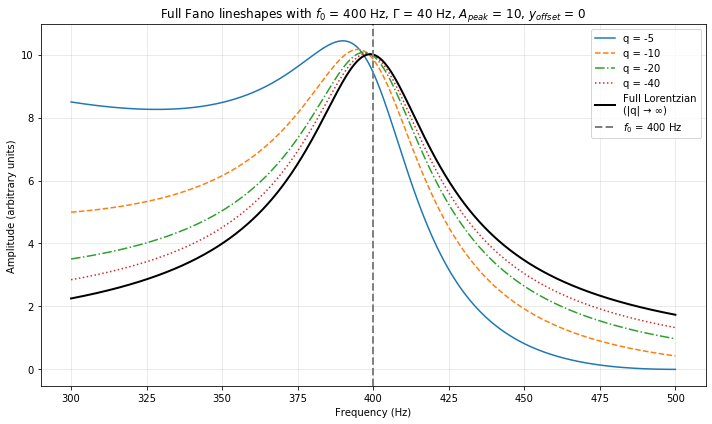

In [12]:
# Parameters
f = np.linspace(300, 500, 500)
f0 = 400
gamma = 40
A_peak = 10
y_offset = 0
q_values = [-5, -10, -20, -40]
linestyles = ['-', '--', '-.', ':']

plt.figure(figsize=(10, 6))
for q, ls in zip(q_values, linestyles):
    y = fano_full(f, f0, gamma, q, A_peak, y_offset)
    plt.plot(f, y, linestyle=ls, label=f'q = {q}')
plt.plot(f, lorentzian_full(f, A_peak, f0, gamma), 'k', linewidth=2, label='Full Lorentzian\n(|q| → ∞)')
plt.axvline(x=f0, color='gray', linestyle='--', linewidth=2, label=f'$f_0$ = {f0} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (arbitrary units)')
plt.title(f'Full Fano lineshapes with $f_0$ = {f0} Hz, Γ = {gamma} Hz, $A_{{peak}}$ = {A_peak}, $y_{{offset}}$ = {y_offset}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion:** 
1. We are reminded by this plot that `q` values with lower magnitude are more asymmetric and that as `|q| → ∞`, this expression goes to the Full Lorentzian from Part 1, which still has a small asymmetry that is visible on the "Full Lorentzian" curve on this plot.
2. We also see that for the peak in the curve is shifted relative to f<sub>0</sub>. Inspection of the Fano equation reveals we should expect the following relationship between $f_0$ that we use in the fano function, and $f_\text{peak}$ which is the location where observe the peak when we graph this function:

$$f_\text{peak} = f_0 + \dfrac{\Gamma}{2q}$$

For a negative `q`, this means that the peak in the function will appear to the left of $f_0$.

## 2.4 Initial Parameter Guesses

Good initial guesses help the fitting algorithm converge faster and avoid local minima. Let's make initial guesses for each of them.

**The asymmetry parameter (q):** Based on our plot above, we could guess that the asymmetry curve is probably in the range of -10 to -40. Let's make our initial guess `q = -20`

In [13]:
q_guess = -20
print("q_guess:", q_guess)

q_guess: -20


**Background offset (y_offset):** This is the value that we observe the curve to eventually decay to. Based on the right side of the curve, we see that this could be a small positive number. But let's assume it is fairly small and just call it zero for now.

In [14]:
offset_guess = 0
print("offset_guess:",offset_guess)

offset_guess: 0


**The resonance frequency (f<sub>0</sub>):**  From visual inspection, we see that the peak occurs at ~ 365 Hz or we can extract this from the data. We know from above that this will likely be an underestimate of $f_0$ by a factor of $|\frac{\Gamma}{2q}|$, but with q_guess being as high as it is, this shift will be relatively small so we won't try to correct for it in this guess. 

In [15]:
f0_guess = x_data[np.argmax(y_data)]
print("f0_guess:", f0_guess)

f0_guess: 363


**Peal Amplitude (A_peak)**: The peak's height, above the offset.

In [16]:
A_guess = np.max(y_data) - offset_guess
print("A_guess", A_guess)

A_guess 6.2


**The damping parameter, Gamma (Γ)**: We will use our same approach as for the Full Lorentzian. This is to use the full width of the peak at $A_\text{peak}/\sqrt{2}$, but in this case we need to account for the y_offset value. By inspection of the plot above, this looks to be ~ 20-25 Hz.

In [17]:
max_over_root2 = A_guess / np.sqrt(2) + offset_guess
indices_half = np.where(y_data >= max_over_root2)[0]
if len(indices_half) >= 2:
    Gamma_guess = x_data[indices_half[-1]] - x_data[indices_half[0]]
else:
    Gamma_guess = 25  # Fallback default
print("gamma_guess:", Gamma_guess)

gamma_guess: 20


Let's pack all of these guesses into a list

In [18]:
p0_guesses = [f0_guess, Gamma_guess, q_guess, A_guess, offset_guess]

Let's visualize the function vs the data using these initial estimates

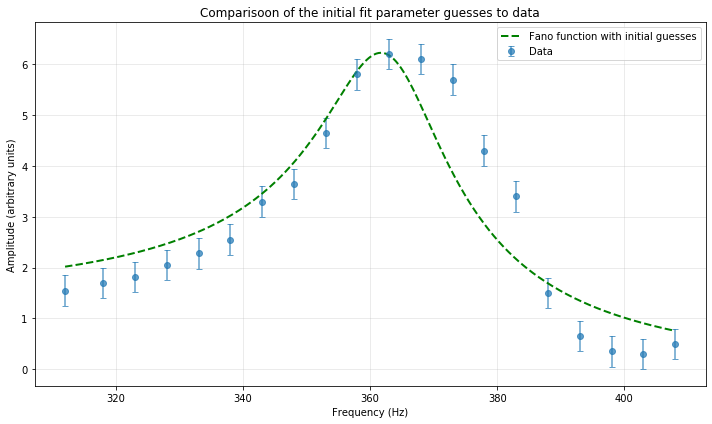

In [19]:
# Visualize initial guesses vs data
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='o', linestyle='', 
             capsize=3, label="Data", alpha=0.7)
plt.plot(x_model, fano_full(x_model, *p0_guesses), 'g--', linewidth=2, 
         label=f"Fano function with initial guesses")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (arbitrary units)")
plt.title("Comparisoon of the initial fit parameter guesses to data")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion:** It looks like some of our estimates were quite reasonable, so let's proceed with the fit. 

## 2.5 Performing the fit to the Full Fano function

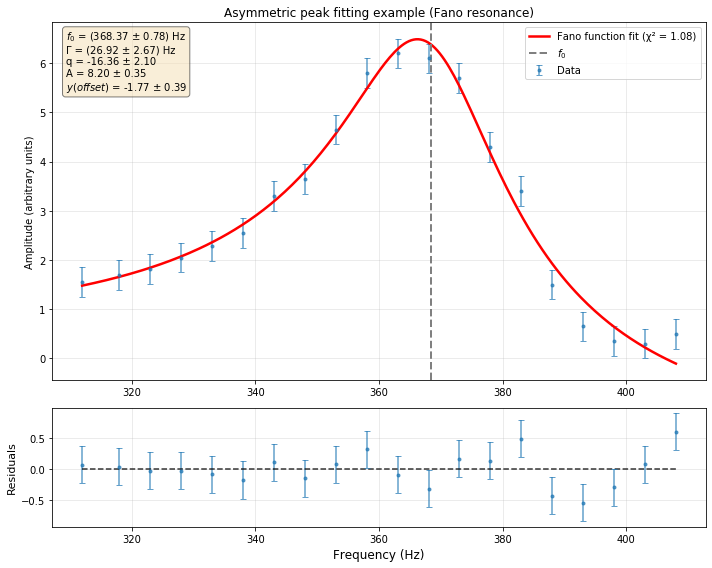

In [20]:
# The fano fit of the asymmetric data
fit_params, fit_cov = curve_fit(fano_full, x_data, y_data, p0=p0_guesses, sigma=y_sigma, absolute_sigma=True)

# Extract fitted parameters and uncertainties
f0_fit, gamma_fit, q_fit, A_fit, offset_fit = fit_params
f0_unc, gamma_unc, q_unc, A_unc, offset_unc = np.sqrt(np.diag(fit_cov))

# Make plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8), 
                       gridspec_kw={'height_ratios': [3, 1]})

# Top panel
y_fit = fano_full(x_model, *fit_params)

ax[0].errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
               capsize=3, label="Data", alpha=0.7)
ax[0].plot(x_model, y_fit, 'r-', linewidth=2.5, 
           label=f"Fano function fit (χ² = {chi2:.2f})")

# Mark f_0 with a vertical line
ax[0].axvline(x=f0_fit, color='gray', linestyle='--', linewidth=2, label=f'$f_0$')

# Add text box with fit parameters
textstr = (
    f'$f_0$ = ({f0_fit:.2f} ± {f0_unc:.2f}) Hz\n'
    + f'Γ = ({gamma_fit:.2f} ± {gamma_unc:.2f}) Hz\n'
    + f'q = {q_fit:.2f} ± {q_unc:.2f}\n'
    + f'A = {A_fit:.2f} ± {A_unc:.2f}\n'
    + f'$y(offset)$ = {offset_fit:.2f} ± {offset_unc:.2f}'
)
ax[0].text(0.02, 0.98, textstr, transform=ax[0].transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[0].set_ylabel("Amplitude (arbitrary units)") 
ax[0].set_title(f"Asymmetric peak fitting example (Fano resonance)")
ax[0].legend(loc='upper right')
ax[0].grid(True, alpha=0.3)

# Bottom panel: Residuals
residual = y_data - fano_full(x_data, *fit_params)
ax[1].errorbar(x_data, residual, yerr=y_sigma, marker='.', linestyle='', capsize=3, alpha=0.7)
ax[1].hlines(0, np.min(x_data), np.max(x_data), lw=1.5, alpha=0.8, color="k", linestyle="--")
ax[1].set_xlabel("Frequency (Hz)", fontsize=12)
ax[1].set_ylabel("Residuals", fontsize=11)
ax[1].grid(True, alpha=0.3)
ax[1].legend

plt.tight_layout()
plt.show()

**Discussion:** We see that the overall fit looks reasonably good. We see a possible pattern in the right tail as the function looks to continue to be going downward when the data are curving back upward. For our purposes this chi-squared near 1 and reasonably well-behaved residuals gives us confidence that the Fano function describes our data well.

**More discussion:** Our system has a natural resonance frequency of $f_0$, which is where we would expect to see the peak in our data if the asymmetries weren't present. However, the asymmetry in our data causes there to be difference between the apparent peak in our data and the resonance frequency $f_0$ found in the fitting. 

**Take-home message:** Although $f_0$ doesn't line up with the apparent peak in the data, it represents the natural harmonic resonance frequency, which is the quantity you want for your subsequent analyses.